[(0.999993, 14.199833333333332), (0.997529, 13.614766666666666), (0.995399, 13.084966666666666), (0.992675, 12.410400000000001), (0.990626, 11.626066666666667), (0.988541, 11.015099999999999), (0.985678, 10.249466666666667), (0.98344, 9.564866666666667), (0.981343, 8.774676666666666), (0.978164, 8.040566666666665), (0.976388, 7.363093333333333), (0.97401, 6.674106666666667), (0.97162, 5.925376666666666), (0.968785, 6.46584), (0.966485, 6.9339233333333326), (0.965424, 7.078966666666666), (0.964831, 7.254636666666667), (0.963585, 7.468556666666667), (0.962529, 7.693013333333333), (0.961516, 7.842506666666666), (0.961374, 7.901193333333333), (0.960851, 8.044153333333332), (0.96019, 8.035936666666666), (0.95958, 8.242076666666668), (0.959802, 8.299693333333332), (0.958951, 8.412700000000001), (0.958345, 8.500396666666667), (0.958053, 8.635473333333334), (0.957665, 8.63072), (0.956939, 8.775966666666667), (0.956641, 8.944633333333334), (0.955884, 9.070073333333333), (0.955403, 9.21514333333

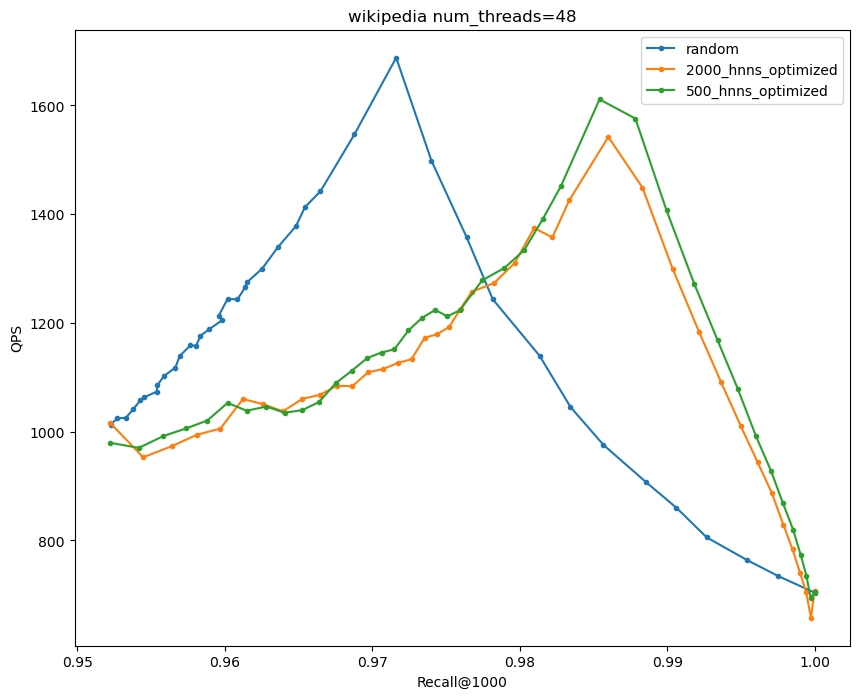

In [5]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

dataset = 'deep100m'
dataset = 'wikipedia'
log_path = "/home/zhengweiguo/liuchengjun/HybridNNS/log/"
config = json.loads(open('config.json').read())
M, efs = config[dataset]["M"], config[dataset]["efs"]
dim = config[dataset]["dim"]
efc = 1000
ck_ts = 2000
k = 1000

num_threads = 48
plt.figure(figsize=(10, 8))

def get_recall_time(prefix):
    recall_time = []
    logfile_path = os.path.join(log_path, prefix)
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        curr = []
        for line in lines:
            if 'model_path' in line: continue
            if 'Search time: ' in line:
                curr.append(float(line.split(': ')[1]))
            elif f'Recall@{k}' in line:
                avg = np.mean(curr)
                curr.clear()
                curr.append(avg)
                curr.append(float(line.split(': ')[1]))
                recall_time.append((curr[1], curr[0]))
                curr = []
    print(recall_time)
    plt.plot([x[0] for x in recall_time], [10000 / x[1] for x in recall_time], '.-')
    return recall_time

legends = []

method = 'random'
ck_ts = 2000
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
recall_time_random = get_recall_time(prefix)
legends.append(f'{method}')

method = 'hnns_optimized'
ck_ts = 2000
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
recall_time_hnns_optimized_ck_ts_2000 = get_recall_time(prefix)
legends.append(f'{ck_ts}_{method}')

# method = 'hnns_optimized'
# ck_ts = 1000
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

method = 'hnns_optimized'
ck_ts = 500
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
recall_time_hnns_optimized_ck_ts_1000 = get_recall_time(prefix)
legends.append(f'{ck_ts}_{method}')

# method = 'hnns'
# ck_ts = 2000
# prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}.nthread_{num_threads}.{method}.log'
# recall_time_hnns = get_recall_time(prefix)
# legends.append(f'{ck_ts}_{method}')

print(legends)


# ax1 = plt.axes([0.1, 0.1, 0.8, 0.8])  # [left, bottom, width, height]
# plt.plot([x[0] for x in recall_time_hnns], [10000 / x[1] for x in recall_time_hnns], 'b*-')
# plt.plot([x[0] for x in recall_time_hnns_optimized], [10000 / x[1] for x in recall_time_hnns_optimized], 'g*-')
plt.legend(legends)
# plt.legend(['random', 'hnns'])
plt.xlabel(f'Recall@1000')
plt.title(f'{dataset} num_threads={num_threads}')
plt.ylabel('QPS')

# ax2 = plt.axes([0.05, 0.6, 0.2, 0.3])  # [left, bottom, width, height]，放置在左上角
# x_zoom_random = [x for x in recall_time_random if 0.998 <= x[0] <= 1.000]
# x_zoom_hnns = [x for x in recall_time_hnns if 0.998 <= x[0] <= 1.000]
# plt.plot([x[0] for x in x_zoom_random], [10000 / x[1] for x in x_zoom_random], 'r*-')
# plt.plot([x[0] for x in x_zoom_hnns], [10000 / x[1] for x in x_zoom_hnns], 'b*-')

plt.show()